# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=260769 #this MUST be updated to your candidate number so that you get a unique data sample

In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CHIRAG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CHIRAG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\CHIRAG\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['look', 'back', 'at', 'all', 'the', 'times', 'in', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [5]:
training_data   # Displayed Training data for understanding

[(['look', 'back', 'at', 'all', 'the', 'times', 'in', ...], 'pos'),
 (['because', 'the', 'press', 'screening', 'of', '"', ...], 'pos'),
 (['a', 'standoff', '.', 'a', 'man', 'holds', 'a', ...], 'pos'),
 (['capsule', ':', 'earthy', ',', 'experimental', ',', ...], 'pos'),
 (['jerry', 'springer', 'has', 'got', 'nothing', 'on', ...], 'pos'),
 (['bruce', 'willis', 'and', 'sixth', 'sense', ...], 'pos'),
 (['if', 'you', "'", 're', 'the', 'type', 'of', 'person', ...], 'pos'),
 (['steve', 'soderbergh', "'", 's', '"', 'sex', ',', ...], 'pos'),
 (['on', 'the', 'basis', 'of', 'this', 'film', 'alone', ...], 'pos'),
 (['i', "'", 've', 'never', 'been', 'a', 'huge', 'fan', ...], 'pos'),
 (['when', 'people', 'are', 'talking', 'about', 'good', ...], 'pos'),
 (['after', 'the', 'terminally', 'bleak', 'reservoir', ...], 'pos'),
 (['>', 'from', 'the', 'commercials', ',', 'this', ...], 'pos'),
 (['the', 'summer', 'movie', 'season', 'is', 'always', ...], 'pos'),
 (['is', 'jimmy', 'stewart', 'the', 'greatest', 

In [6]:
pos_test_ids, pos_train_ids = split_data('pos_review_ids')
neg_test_ids, neg_train_ids = split_data('neg_review_ids')

In [7]:
from nltk.probability import FreqDist

document = FreqDist(training_data[0][0])
document

FreqDist({',': 86, 'the': 61, '.': 44, 'a': 34, 'of': 33, 'and': 24, 'in': 19, "'": 17, 'is': 16, 'to': 13, ...})

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

def normalise(wordlist):
    lowered=[word.lower() for word in wordlist] #don't actually need this as already lowered
    filtered=[word for word in lowered if word.isalpha() and word not in stop]
    return filtered

normalise(training_data[0][0])

['look',
 'back',
 'times',
 'life',
 'fork',
 'path',
 'future',
 'sort',
 'decision',
 'made',
 'better',
 'worse',
 'irrevocably',
 'altered',
 'course',
 'existence',
 'time',
 'time',
 'everyone',
 'thinks',
 'roads',
 'taken',
 'things',
 'might',
 'turned',
 'choice',
 'different',
 'perhaps',
 'even',
 'dizzying',
 'contemplate',
 'seemingly',
 'minor',
 'action',
 'catching',
 'train',
 'example',
 'could',
 'equally',
 'profound',
 'yet',
 'less',
 'obvious',
 'impact',
 'maybe',
 'met',
 'significant',
 'reached',
 'platform',
 'seconds',
 'later',
 'film',
 'makers',
 'less',
 'fascinated',
 'issues',
 'destiny',
 'anyone',
 'else',
 'shortage',
 'movies',
 'subject',
 'best',
 'bunch',
 'probably',
 'made',
 'late',
 'polish',
 'director',
 'krzysztof',
 'kieslowski',
 'obsessed',
 'questions',
 'fate',
 'chance',
 'themes',
 'weave',
 'way',
 'many',
 'movies',
 'including',
 'decalogue',
 'double',
 'life',
 'veronique',
 'triptych',
 'blue',
 'white',
 'red',
 'however'

In [9]:
training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training_data]
testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing_data]

training_norm[0]

(FreqDist({'life': 9, 'one': 9, 'train': 6, 'gerry': 6, 'time': 5, 'different': 5, 'sliding': 5, 'doors': 5, 'movies': 4, 'kieslowski': 4, ...}),
 'pos')

In [10]:
pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist
        
pos_freq_dist

FreqDist({'film': 3639, 'one': 2148, 'movie': 1764, 'like': 1230, 'story': 899, 'good': 863, 'also': 863, 'even': 848, 'time': 833, 'well': 786, ...})

In [11]:
def check_expectations(a_word_list,expectation,pos=pos_freq_dist,neg=neg_freq_dist):
    results=[]
    for word in a_word_list:
        pos_freq=pos.get(word,0)
        neg_freq=neg.get(word,0)
        diff=pos_freq-neg_freq
        if diff*expectation>0:
            print("As expected: for {} difference is {}".format(word,diff))
            results.append((word,diff,'yes'))
        else:
            print("Contrary to expectations: for {} difference is {}".format(word,diff))
            results.append((word,diff,'no'))
            
    return results

In [12]:
posdiff=pos_freq_dist-neg_freq_dist
posdiff

FreqDist({'film': 802, 'life': 404, 'also': 342, 'great': 279, 'story': 276, 'well': 243, 'best': 239, 'many': 221, 'one': 196, 'films': 192, ...})

In [13]:
posdiff.most_common()

[('film', 802),
 ('life', 404),
 ('also', 342),
 ('great', 279),
 ('story', 276),
 ('well', 243),
 ('best', 239),
 ('many', 221),
 ('one', 196),
 ('films', 192),
 ('world', 174),
 ('family', 162),
 ('performance', 150),
 ('although', 142),
 ('seen', 142),
 ('quite', 138),
 ('man', 135),
 ('love', 127),
 ('true', 127),
 ('way', 121),
 ('new', 121),
 ('american', 121),
 ('makes', 120),
 ('war', 120),
 ('always', 119),
 ('john', 117),
 ('character', 116),
 ('see', 115),
 ('two', 112),
 ('years', 111),
 ('especially', 111),
 ('disney', 110),
 ('yet', 107),
 ('characters', 106),
 ('job', 105),
 ('performances', 105),
 ('picture', 104),
 ('perfect', 104),
 ('first', 102),
 ('takes', 102),
 ('role', 102),
 ('however', 101),
 ('wars', 100),
 ('small', 99),
 ('still', 98),
 ('star', 98),
 ('right', 96),
 ('jackie', 96),
 ('different', 95),
 ('people', 94),
 ('gives', 94),
 ('men', 90),
 ('beautiful', 90),
 ('father', 90),
 ('fiction', 87),
 ('may', 87),
 ('truman', 86),
 ('day', 85),
 ('wonderf

In [14]:
def Frequently(posfreq,negfreq,topk):
    difference=posfreq-negfreq
    sorteddiff=difference.most_common()
    justwords=[word for (word,freq) in sorteddiff[:topk]]
    return justwords

In [15]:
Positive_word_list=Frequently(pos_freq_dist,neg_freq_dist,10)
print(Positive_word_list)

['film', 'life', 'also', 'great', 'story', 'well', 'best', 'many', 'one', 'films']


In [16]:
Negative_word_list =Frequently(neg_freq_dist,pos_freq_dist,10)
print(Negative_word_list)

['movie', 'bad', 'plot', 'script', 'worst', 'boring', 'action', 'get', 'supposed', 'stupid']


### Above, I generated a list of 10 words with positive content and 10 words with negative content. I then removed all stopwords from both the positive and negative lists of words. To analyse the sentiments, I divided the data into positive and negative categories.

2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [17]:
Positive_word_list = ['film', 'life', 'also', 'great', 'story', 'well', 'best', 'many', 'one', 'films']
Negative_word_list = ['movie', 'bad', 'plot', 'script', 'worst', 'boring', 'action', 'get', 'supposed', 'stupid']

from nltk.classify.api import ClassifierI
import random
class SimpleClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

    def classify(self, doc): 
        score = 0
        
        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value
        return "neg" if score < 0 else "pos"

    ##we don't actually need to define the classify_many method as it is provided in ClassifierI
    #def classify_many(self, docs): 
    #    return [self.classify(doc) for doc in docs] 

    def labels(self): 
        return ("pos", "neg")


#Example usage:

Simclassifier = SimpleClassifier(Positive_word_list, Negative_word_list)
print(Simclassifier.classify(FreqDist("My life is great".split())))
print(Simclassifier.classify(FreqDist("This plot is boring".split())))



pos
neg


### Both the classification of positive and negative terms is done here. Whether a sentence contains positive or negative word lists will be determined by this classifier.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [18]:
def classifier_evaluate(cls, test_data):
    '''
    cls: an instance of a classifier object which has a classify method which returns "pos" or "neg"
    test_data: a list of pairs where each pair is a FreqDist rep of a doc and its label
  
    returns: float point number which is the accuracy of the classifier on the test data provided 
    '''
    acc = 0
    docs,goldstandard=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1
    
    return acc / (len(test_data))

In [19]:
def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
    #now normalise and create bag-of-words FreqDist representations
    training_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in training]
    testing_norm=[(FreqDist(normalise(wordlist)),label) for (wordlist,label) in testing]
    return training_norm, testing_norm

In [20]:
random.seed(candidateno)  #set the random seeds so these random splits are always the same
training,testing=get_train_test_data()

training[0]

(FreqDist({'life': 9, 'one': 9, 'train': 6, 'gerry': 6, 'time': 5, 'different': 5, 'sliding': 5, 'doors': 5, 'movies': 4, 'kieslowski': 4, ...}),
 'pos')

In [21]:
#here I am going to create an instance of a very simple classifier 

Positive_word_list = ['film', 'life', 'also', 'great', 'story', 'well', 'best', 'many', 'one', 'films']
Negative_word_list = ['movie', 'bad', 'plot', 'script', 'worst', 'boring', 'action', 'get', 'supposed', 'stupid']
movie_classifier1 = SimpleClassifier(Positive_word_list, Negative_word_list)

#Evaluate classifier
#The function requires two arguments:
# 1. Word list based classifer
# 2. A list (or generator) of labelled test items
score = classifier_evaluate(movie_classifier1, testing)  
print(score)

0.5566666666666666


In [22]:
docs,labels=zip(*testing)
preds=movie_classifier1.classify_many(docs)

In [23]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):
    
        (self.c1,self.c2)=classes
        #self.predictions=predictions
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    
    def precision(self):
        p=0
        p = self.TP / (self.TP + self.FP)
    
        return p
  
    def recall(self):
        r=0
        r = self.TP / (self.TP + self.FN)
    
        return r
  
    def f1(self):
        f1=0
        #put your code to compute f1 here
        p=self.precision()
        r=self.recall()
        f1=2*p*r/(p+r)
        return f1 

In [24]:
mystring="worst"
mystring.isalpha()

True

In [25]:
#docs will contain the documents to classify, labels contains the corresponding gold standard labels
docs,labels=zip(*testing)
senti_cm=ConfusionMatrix(movie_classifier1.classify_many(docs),labels)
print(senti_cm.TP)
print(senti_cm.FP)
print(senti_cm.TN)
print(senti_cm.FN)

267
233
67
33


In [26]:
senti_cm.precision()

0.534

In [27]:
senti_cm.recall()

0.89

In [28]:
senti_cm.f1()

0.6675000000000001

### No, it is not reasonable to evaluate the classifier in terms of accuracy because accuracy provides a single measure of how well the classifier works but fails to tell how well it works within each class, which is especially problematic when we have imbalanced data. For example, if we need to predict spam emails where 95% are spam and 5% are not spam, the classifier will say it is 95% correct. So, if we have one class that accounts for 95% of the data, simply predicting that class will get us 95% correct, which is not the case. For balanced data with equal number of positive and negative examples in the true class accuracy is a reasonable measure of how well the classifier is doing because we have balanced data.

4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

In [29]:
from nltk.classify import NaiveBayesClassifier # just add NLTK NBclassifier
NB_Classifier = NaiveBayesClassifier.train(training)

In [30]:
NB_Classifier.classify_many(docs)

['pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',


In [31]:
NBscore = classifier_evaluate(NB_Classifier, testing)
print(NBscore)

0.6766666666666666


In [32]:
cm = ConfusionMatrix(NB_Classifier.classify_many(docs),labels,classes=("pos","neg"))
cm.precision()

0.6104166666666667

In [33]:
cm.recall()

0.9766666666666667

In [34]:
cm.f1()

0.7512820512820514

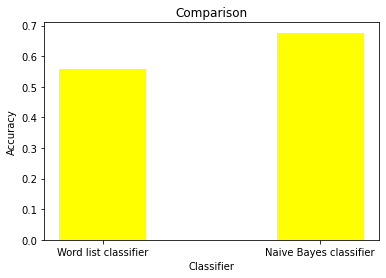

In [35]:
c = {"Word list classifier": score, "Naive Bayes classifier": NBscore }
courses = list(c.keys())
values = list(c.values())
plt.bar(courses, values, color ='yellow', width = 0.4)
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison")
plt.show()

### Based on all the evaluation metrices including accuracy, precision, recall and F-score the performance of Naive Bayes classifier is much better when compared to word list classifier

5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


In [36]:
def above_threshold(posfreq,negfreq,threshold):
  difference=posfreq-negfreq
  sorteddiff=difference.most_common()
  filtered=[w for (w,f) in sorteddiff if f>threshold]
  return filtered

In [37]:
class SimClassifier_ot(SimpleClassifier):# this class has been added to take whole training data

    def __init__(self,k):
        self._k=k

    def train(self,training_data):

        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist

        self._pos=above_threshold(pos_freq_dist,neg_freq_dist,self._k)
        self._neg=above_threshold(neg_freq_dist,pos_freq_dist,self._k)

In [38]:
movie_classifier2 = SimClassifier_ot(100)
#train it
movie_classifier2.train(training)
#evaluate it on the test data
score=classifier_evaluate(movie_classifier2,testing)
print(score)

0.5166666666666667


In [39]:
threshold=100
classifiers={"Word List Thresh":SimClassifier_ot(threshold)}

number_of_runs=3

results={}
for key in classifiers.keys():

    results[key]=0

for i in range(number_of_runs):
    training,testing=get_train_test_data()
    docs,labels=zip(*testing)
    for name,classifier in classifiers.items():
        classifier.train(training)
        senti_cm=ConfusionMatrix(classifier.classify_many(docs),labels)
        #print("The precision of {} classifier is {}".format(name,senti_cm.precision()))
        #I have only done precision here but you should do recall and F1 as well
        results[name]=results[name]+(senti_cm.precision()/number_of_runs)
from random import sample

sample_sizes = [2, 10, 50, 100, 200, 400, 600, 700]
results = {}

for size in sample_sizes:
    res = {}

    for i in range(number_of_runs):
        training, testing = get_train_test_data()

        positive_training = [(doc, label) for (doc, label) in training if label == "pos"]
        negative_training = [(doc, label) for (doc, label) in training if label == "neg"]
        training_sample = sample(positive_training, size) + sample(negative_training, size)
        for name, classifier in classifiers.items():
            classifier.train(training_sample)
            accuracy = classifier_evaluate(classifier, testing)
            #print("The accuracy of {} classifier with training sample size {} is {}".format(name,size, accuracy))
            res[name] = res.get(name, 0) + accuracy / number_of_runs
    results[size] = res

results

{2: {'Word List Thresh': 0.5},
 10: {'Word List Thresh': 0.5},
 50: {'Word List Thresh': 0.51},
 100: {'Word List Thresh': 0.5},
 200: {'Word List Thresh': 0.5544444444444444},
 400: {'Word List Thresh': 0.5772222222222222},
 600: {'Word List Thresh': 0.5577777777777777},
 700: {'Word List Thresh': 0.5572222222222222}}

In [40]:
df = pd.DataFrame(results)
df = df.transpose()
df

,Word List Thresh
2,0.500000
10,0.500000
50,0.510000
100,0.500000
200,0.554444
400,0.577222
600,0.557778
700,0.557222


Text(0.5, 0, 'Sample Size')

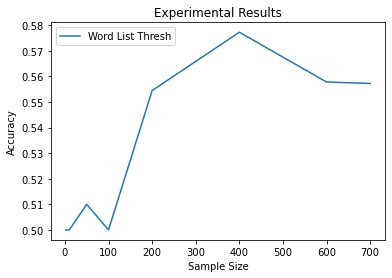

In [41]:
ax = df.plot(kind="line", title="Experimental Results")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Sample Size")

###  5a.   According to the graph, increasing the amount of training data seems to improve up to a certain point                       (sample size around 400). After this stage, performance appears to decline.

###   5b.  Based on the performance of all evaluation metrices I would like to work in this field using Naive Bayes classifier since it had accuracy, precision, recall, F1 score all higher than the word list classifier.

In [42]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

#filepath="/content/NLassignment2022 (7).ipynb"
filepath="NLassignment2022.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is -1


C:\ProgramData\Anaconda3\lib\site-packages\nbformat\current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


In [ ]:
# THE CODE TO CHECK SUBMISSION LENGTH OF MARKDOWN CELLS IS NOT WORKING AT ALL.